In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import experimental, Conv2D, MaxPooling2D, Dense, Flatten
import matplotlib.pyplot as plt

2024-02-06 13:53:25.824206: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-06 13:53:26.045154: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-06 13:53:27.018835: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-06 13:53:27.018878: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-06 13:53:27.231073: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

In [2]:
IMAGE_SIZE=256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 10

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory("../leaves/images/",
                                                    shuffle=True,
                                                    image_size=(IMAGE_SIZE,IMAGE_SIZE),
                                                    batch_size=BATCH_SIZE)

Found 13128 files belonging to 8 classes.


In [4]:
class_names = dataset.class_names

In [5]:
len(dataset) #Is a batch of 32 images so its all the picture / by batch

411

(32, 256, 256, 3)


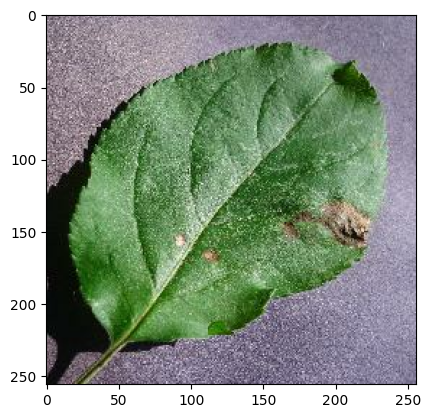

In [6]:
for image_batch, label_batch in dataset.take(1):
    plt.imshow(image_batch[0].numpy().astype("uint8"))
    print(image_batch.shape) #size of batch, size image, nb of color(rgb)

In [7]:
# 80% to training
# After each epoch 10% will be usr to verify how close are we for the good value
# Last 10% to test
def get_dataset_partition_tf(ds, train_split = 0.8, cv_split = 0.1, test_split = 0.1, shuffle = True, shuffle_size = 10000):
	if shuffle:
		ds = ds.shuffle(shuffle_size, seed = 12)
	len_train_dataset = int(len(ds) * train_split)
	len_cv = int(len(ds) * cv_split)
	train_dataset = ds.take(len_train_dataset)
	cv_dataset = ds.skip(len_train_dataset).take(len_cv)
	test_dataset = ds.skip(len_train_dataset + len_cv)
	return train_dataset, cv_dataset, test_dataset

In [8]:
training_set, validation_set, test_set = get_dataset_partition_tf(dataset)

In [9]:
print(len(test_set))
print(len(validation_set))
print(len(training_set))

42
41
328


In [10]:
training_set = training_set.cache().shuffle(10000).prefetch(buffer_size=tf.data.AUTOTUNE)
validation_set = validation_set.cache().shuffle(10000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_set = test_set.cache().shuffle(10000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [11]:
resize_and_rescale = Sequential([
    experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    experimental.preprocessing.Rescaling(1.0/255)
])


In [12]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3
model = Sequential([
	resize_and_rescale,
	Conv2D(32, (3,3), activation = 'relu', input_shape = input_shape),
	MaxPooling2D((2,2)),

	# Conv2D(32, (3,3),  activation = 'relu'),
	# MaxPooling2D((2,2)),

	Flatten(),
	Dense(64, activation = 'relu'),
	Dense(len(class_names), activation = 'softmax')
])
model.build(input_shape=input_shape)

In [13]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 flatten (Flatten)           (32, 516128)              0         
                                                                 
 dense (Dense)               (32, 64)                  33032256  
                                                                 
 dense_1 (Dense)             (32, 8)                   520       
                                                      

In [14]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [15]:
history = model.fit(
    training_set,
    epochs= EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=validation_set,
)

Epoch 1/10


: 